In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
dat_wide = pd.read_csv("../data/region_patients_wide.csv")
print(dat_wide.head())

   location_1  location_2  location_3  location_4  location_5
0          12           7           7           8          15
1          12           4           6           9          10
2           6           6           9           7          12
3          13           9           6          14          10
4          12           3          15           6           6


In [4]:
dat_wide.shape

(30, 5)

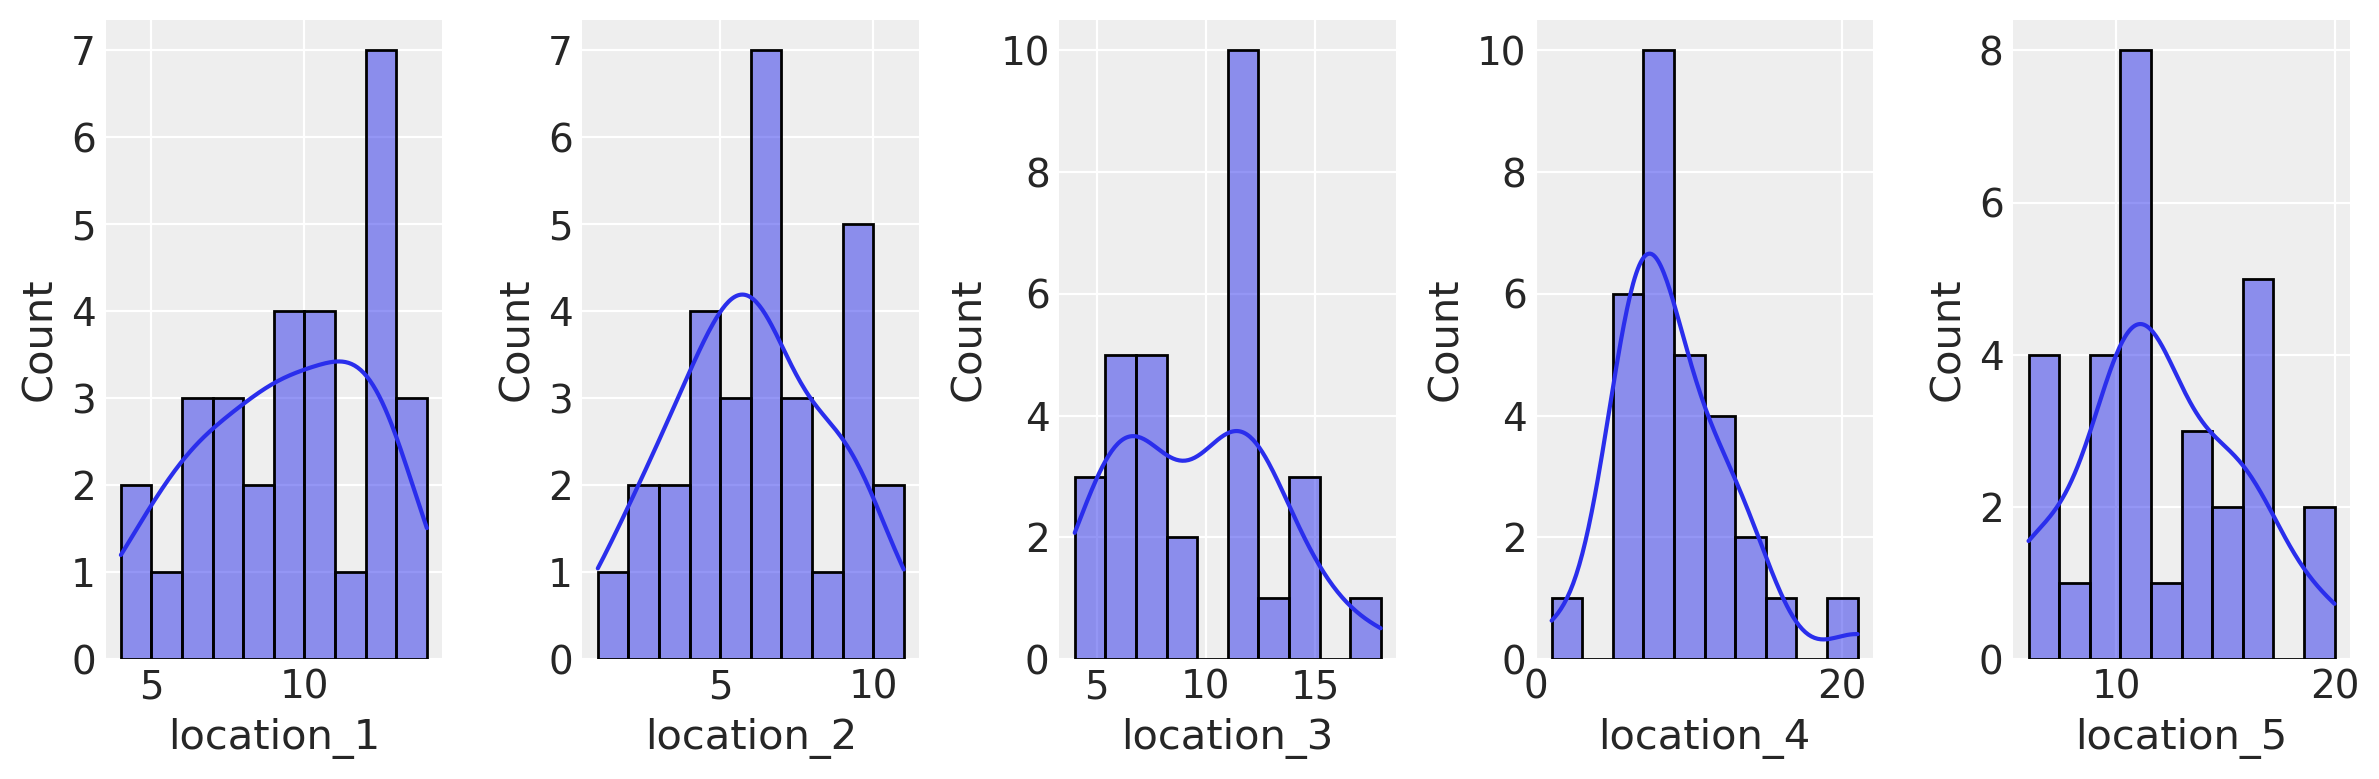

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(dat_wide.columns), figsize=(12, 4))

for i, col in enumerate(dat_wide.columns):
    sns.histplot(
        dat_wide[col], bins=10, kde=True, ax=axes[i]
    )  

plt.tight_layout()
plt.show()

In [6]:
# Fare una copia così da non cambiare il DataFrame originale
dw = dat_wide.copy()

# Reset dell'indice per utilizzarlo come una colonna
dw.reset_index(inplace=True)

# Convertire il DataFrame in formato long utilizzando melt
dat_long = pd.melt(dw, id_vars=['index'], var_name='location', value_name='patients')

# Rinominare la colonna 'index' in 'obs' per maggiore chiarezza
dat_long.rename(columns={'index': 'obs'}, inplace=True)

# Visualizzare il DataFrame risultante
print(dat_long)

     obs    location  patients
0      0  location_1        12
1      1  location_1        12
2      2  location_1         6
3      3  location_1        13
4      4  location_1        12
..   ...         ...       ...
145   25  location_5        11
146   26  location_5        11
147   27  location_5        19
148   28  location_5        11
149   29  location_5        15

[150 rows x 3 columns]


In [7]:
with pm.Model() as model_pooling:
    y_data = pm.ConstantData("y_data", dat_long["patients"])
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)
    rate = pm.Gamma("rate", mu=h_mu, sigma=h_sigma)
    y_obs = pm.Poisson("y_obs", mu=rate, observed=y_data)

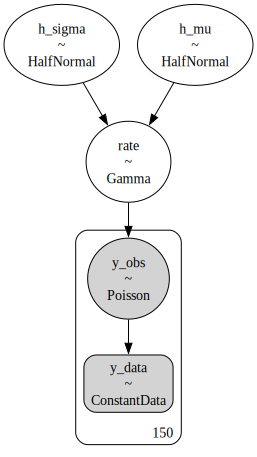

In [8]:
pm.model_to_graphviz(model_pooling)

In [9]:
with model_pooling:
    idata_pooling_prior_pred = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [h_mu, h_sigma, rate, y_obs]


In [10]:
idata_pooling_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [11]:
foo = idata_pooling_prior_pred.prior_predictive.y_obs
foo.shape

(1, 100, 150)

In [12]:
# Extract the likelihood samples
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y_obs
flattened_array = np.ravel(likelihood_samples.values)

print(flattened_array)

[ 0  0  0 ... 14 10 14]


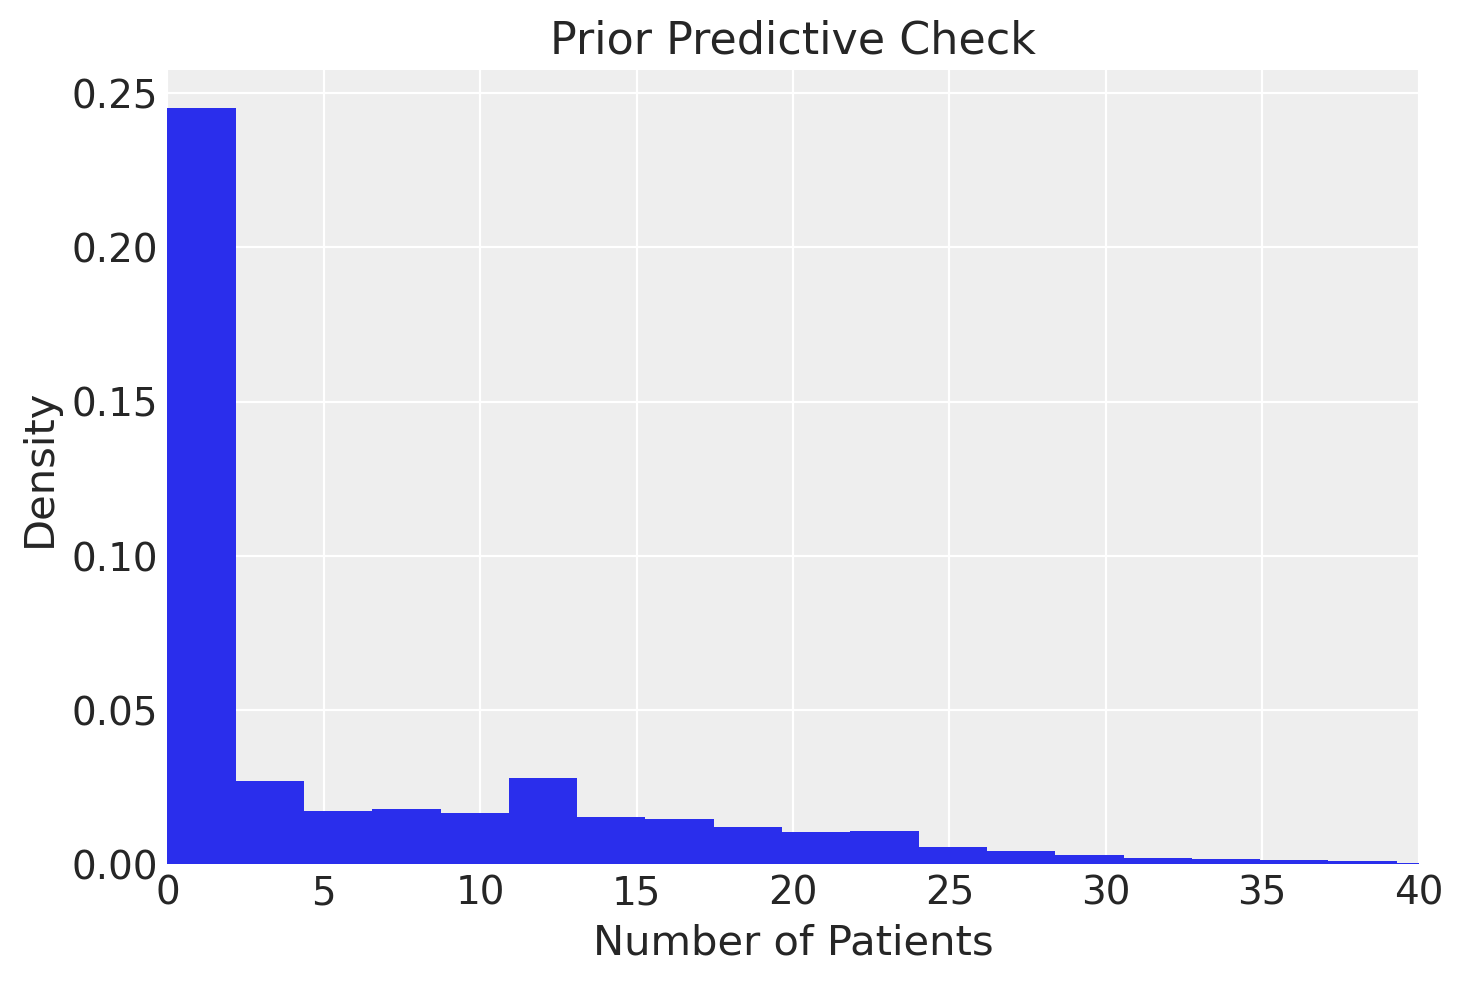

In [13]:
# Plot the prior predictive samples
plt.hist(flattened_array, bins=60, density=True)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40)
plt.show()

In [14]:
with model_pooling:
    idata_pooling = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:17.167726


Sampling...


  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1317.77it/s]


Running chain 1: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1318.89it/s]


Running chain 2: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1320.10it/s]


Running chain 3: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1321.10it/s]


Sampling time = 0:00:01.734850


Transforming variables...


Transformation time = 0:00:00.061988


Computing Log Likelihood...


Log Likelihood time = 0:00:00.133819


In [15]:
az.summary(idata_pooling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,10.130,3.923,2.482,17.807,0.102,0.072,1287.0,851.0,1.51
h_sigma,6.975,8.284,0.035,22.843,2.004,1.442,7.0,7.0,1.59
rate,9.243,0.282,8.774,9.712,0.092,0.068,10.0,57.0,1.33


In [16]:
dat_wide.head()

,location_1,location_2,location_3,location_4,location_5
0,12,7,7,8,15
1,12,4,6,9,10
2,6,6,9,7,12
3,13,9,6,14,10
4,12,3,15,6,6


In [17]:
# The data has two dimensions: obs and location
# The "coordinates" are the unique values that these dimensions can take
coords = {"obs": dat_wide.index, "location": dat_wide.columns}
display(coords)

{'obs': RangeIndex(start=0, stop=30, step=1),
 'location': Index(['location_1', 'location_2', 'location_3', 'location_4', 'location_5'], dtype='object')}

In [18]:
with pm.Model(coords=coords) as model_h:
    # Definizione dei dati
    data = pm.ConstantData("observed_score", dat_wide, dims=("obs", "location"))

    # Iperparametri per la distribuzione Gamma
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)

    # Priori Gamma per ogni località
    lam = pm.Gamma("lam", mu=h_mu, sigma=h_sigma, dims="location")

    # Verosimiglianza Poissoniana per i punteggi
    score = pm.Poisson("score", mu=lam, observed=data, dims=("obs", "location"))

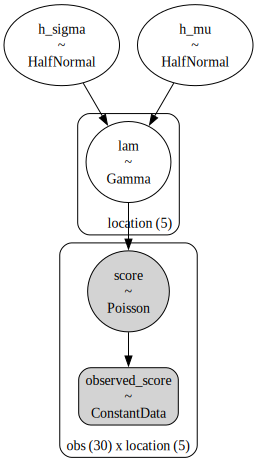

In [19]:
pm.model_to_graphviz(model_h)

In [20]:
with model_h:
    idata_h_prior_pred = pm.sample_prior_predictive()

Sampling: [h_mu, h_sigma, lam, score]


In [21]:
idata_h_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

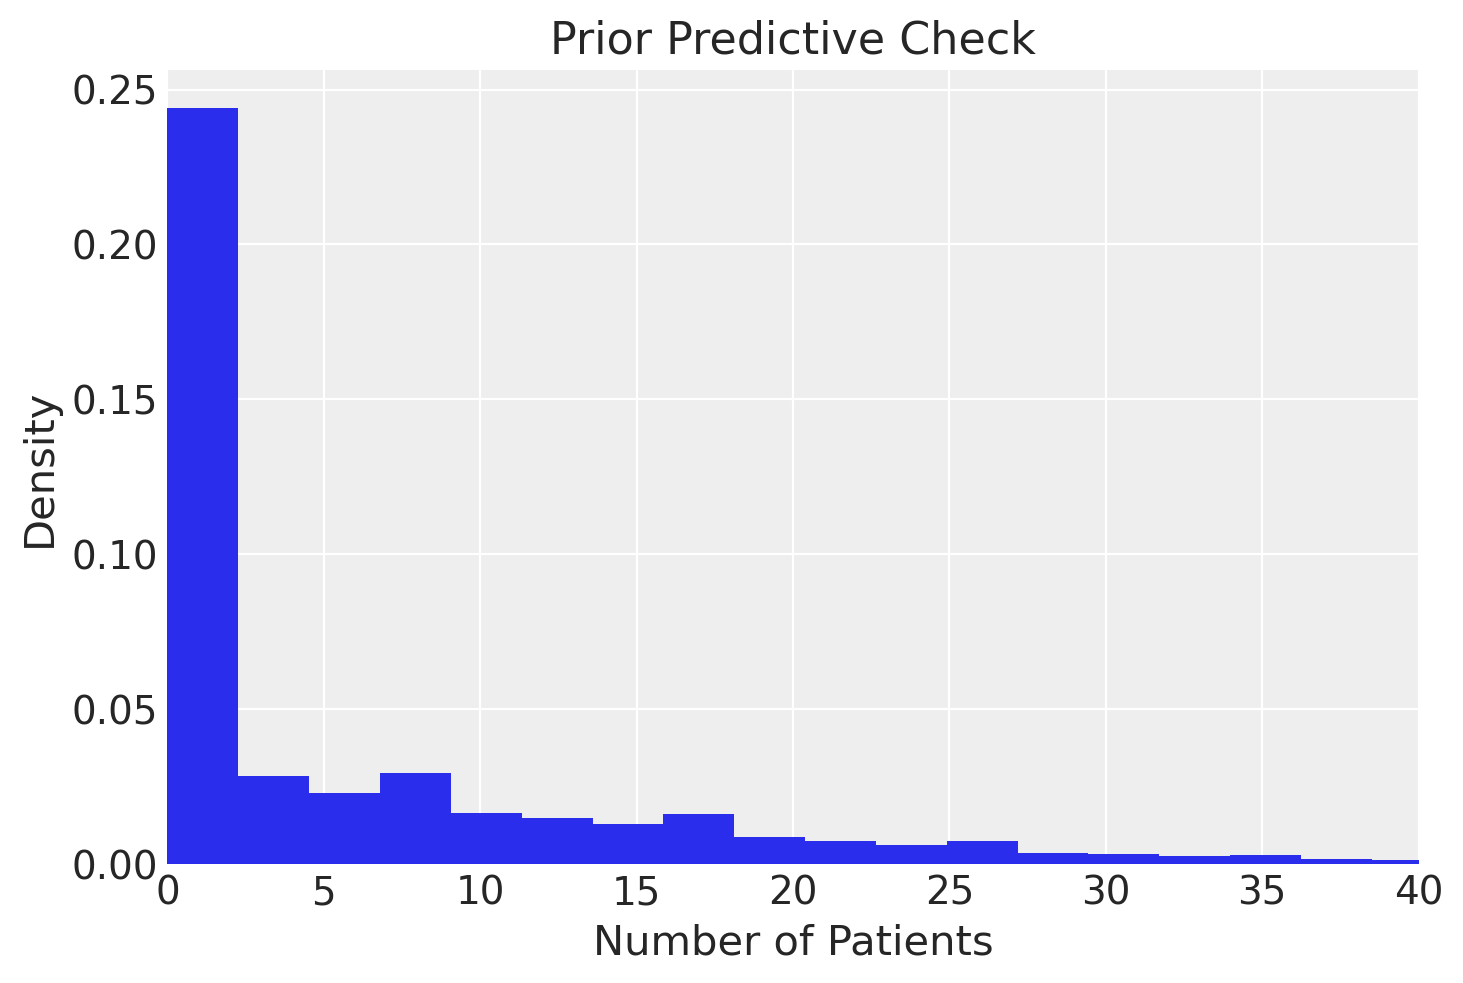

In [22]:
# Extract the likelihood samples
likelihood_samples = idata_h_prior_pred.prior_predictive.score
flattened_array = np.ravel(likelihood_samples.values)

# Plot the prior predictive samples
plt.hist(flattened_array, bins=200, density=True)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40)
plt.show()

In [23]:
with model_h:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:18.744050


Sampling...


  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1284.03it/s]


Running chain 1: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1284.73it/s]


Running chain 2: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1286.03it/s]


Running chain 3: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1287.08it/s]


Sampling time = 0:00:01.673731


Transforming variables...


Transformation time = 0:00:00.060963


Computing Log Likelihood...


Log Likelihood time = 0:00:00.142728


In [24]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,9.62,1.61,6.69,12.74,0.04,0.03,2057.29,1598.01,1.0
h_sigma,3.36,2.01,1.04,6.91,0.05,0.04,2013.34,1671.58,1.0
lam[location_1],9.31,0.55,8.27,10.35,0.01,0.01,4003.82,3244.91,1.0
lam[location_2],6.13,0.46,5.25,6.99,0.01,0.01,3547.22,2761.67,1.0
lam[location_3],9.56,0.55,8.52,10.56,0.01,0.01,4720.41,3062.90,1.0
lam[location_4],8.96,0.53,7.97,9.97,0.01,0.01,4780.96,2985.58,1.0
lam[location_5],11.87,0.64,10.69,13.06,0.01,0.01,4492.37,2966.83,1.0


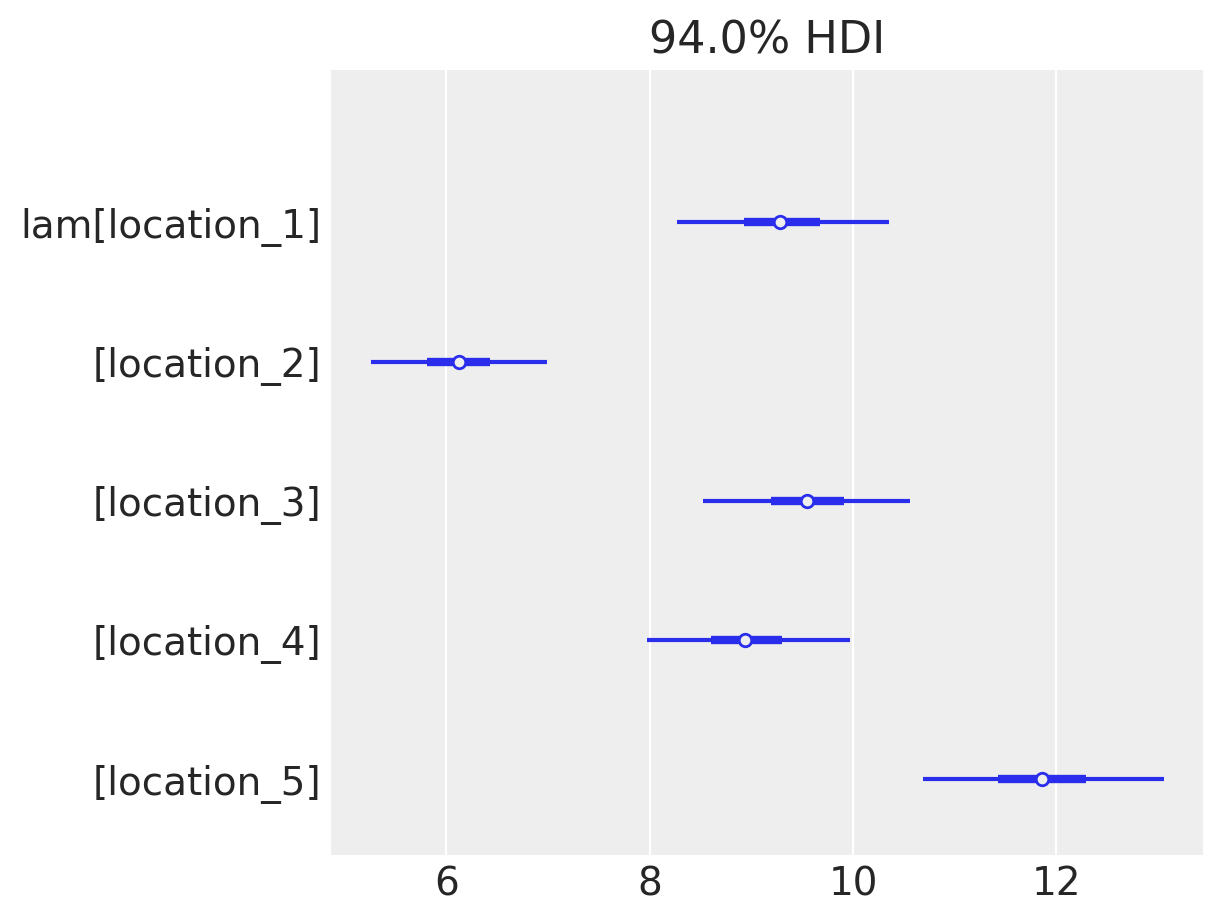

In [25]:
samples_lam = idata.posterior["lam"]
az.plot_forest(samples_lam, combined=True, hdi_prob=0.94)
plt.show()

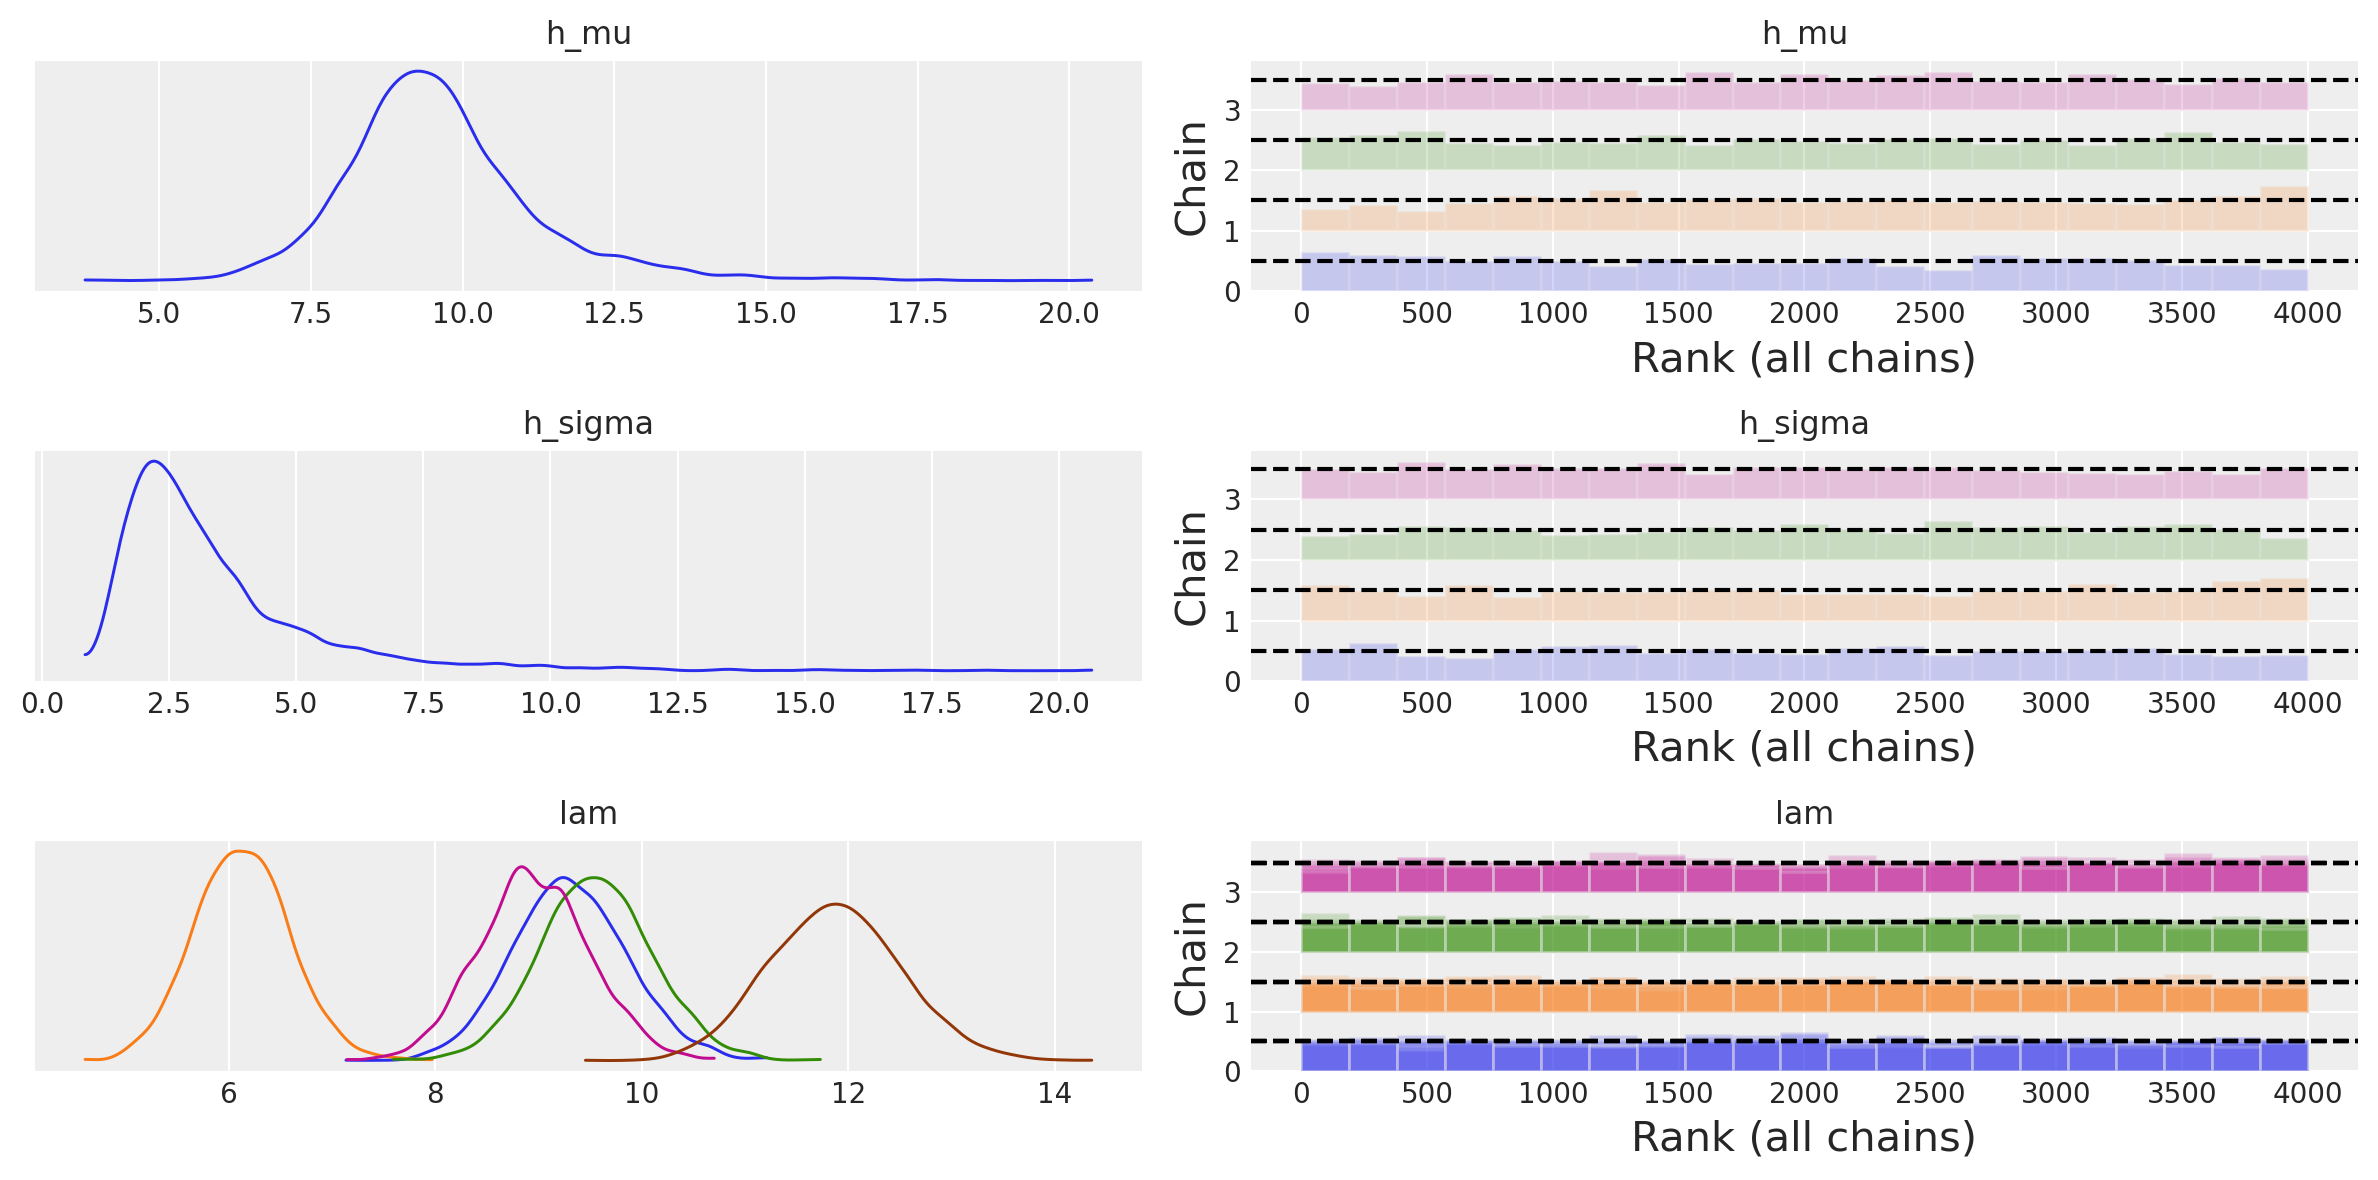

In [26]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [27]:
with model_h:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [score]


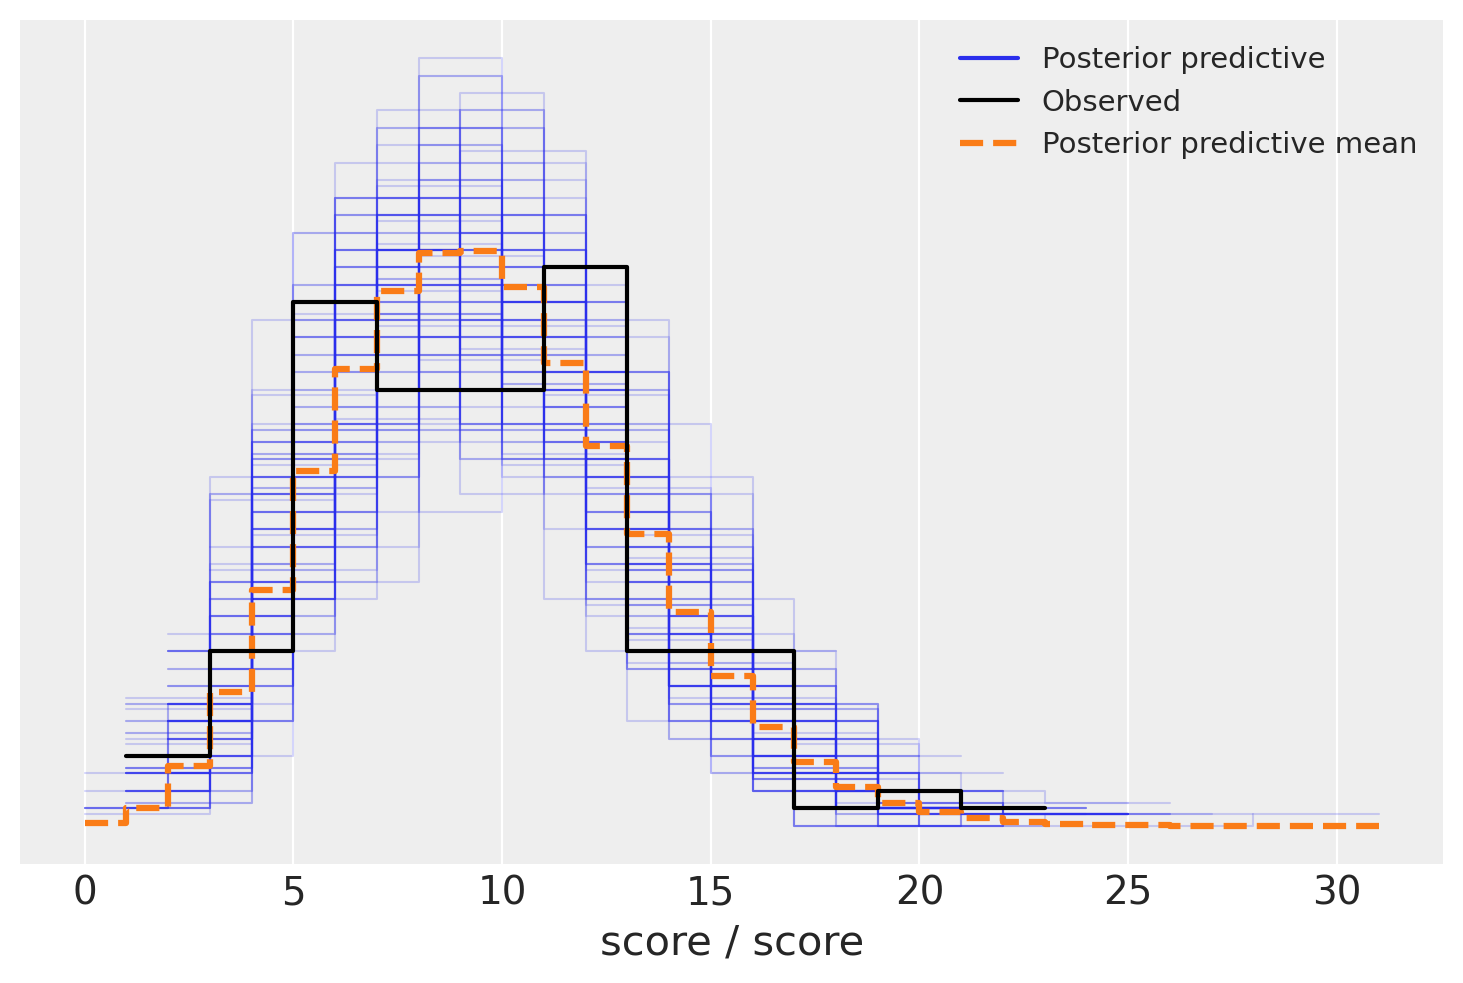

In [28]:
az.plot_ppc(post_pred, num_pp_samples=100)
plt.show()

In [29]:
# Trasformazione del DataFrame in formato long
df_long = dat_wide.melt(var_name="Location", value_name="Value")

In [30]:
df_long["Location_idx"] = df_long["Location"].str.extract("(\d+)").astype(int) - 1
display(df_long)

,Location,Value,Location_idx
0,location_1,12,0
1,location_1,12,0
2,location_1,6,0
3,location_1,13,0
4,location_1,12,0
...,...,...,...
145,location_5,11,4
146,location_5,11,4
147,location_5,19,4
148,location_5,11,4


In [31]:
coords = {
    "obs": np.arange(len(df_long)),
    "location": np.arange(len(df_long['Location'].unique())),
}
coords

{'obs': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),
 'location': array([0, 1, 2, 3, 4])}

In [32]:
with pm.Model(coords=coords) as model_h_long:
    # Definizione dei dati
    data = pm.ConstantData("observed_score", df_long["Value"], dims="obs")
    location_idx = pm.ConstantData("location_idx", df_long["Location_idx"], dims="obs")

    # Iperparametri per la distribuzione Gamma
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)

    # Priori Gamma per ogni località
    lam = pm.Gamma("lam", mu=h_mu, sigma=h_sigma, dims="location")

    # Verosimiglianza Poissoniana per i punteggi
    score = pm.Poisson("score", mu=lam[location_idx], observed=data, dims="obs")

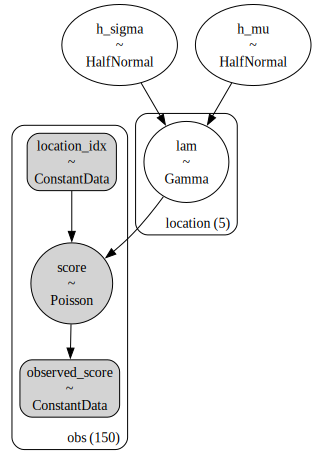

In [33]:
pm.model_to_graphviz(model_h_long)

In [34]:
with model_h_long:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:05.497980


Sampling...


  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1156.61it/s]


Running chain 1: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1157.19it/s]


Running chain 2: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1157.98it/s]


Running chain 3: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1158.70it/s]


Sampling time = 0:00:01.828352


Transforming variables...


Transformation time = 0:00:00.039347


Computing Log Likelihood...


Log Likelihood time = 0:00:00.115979


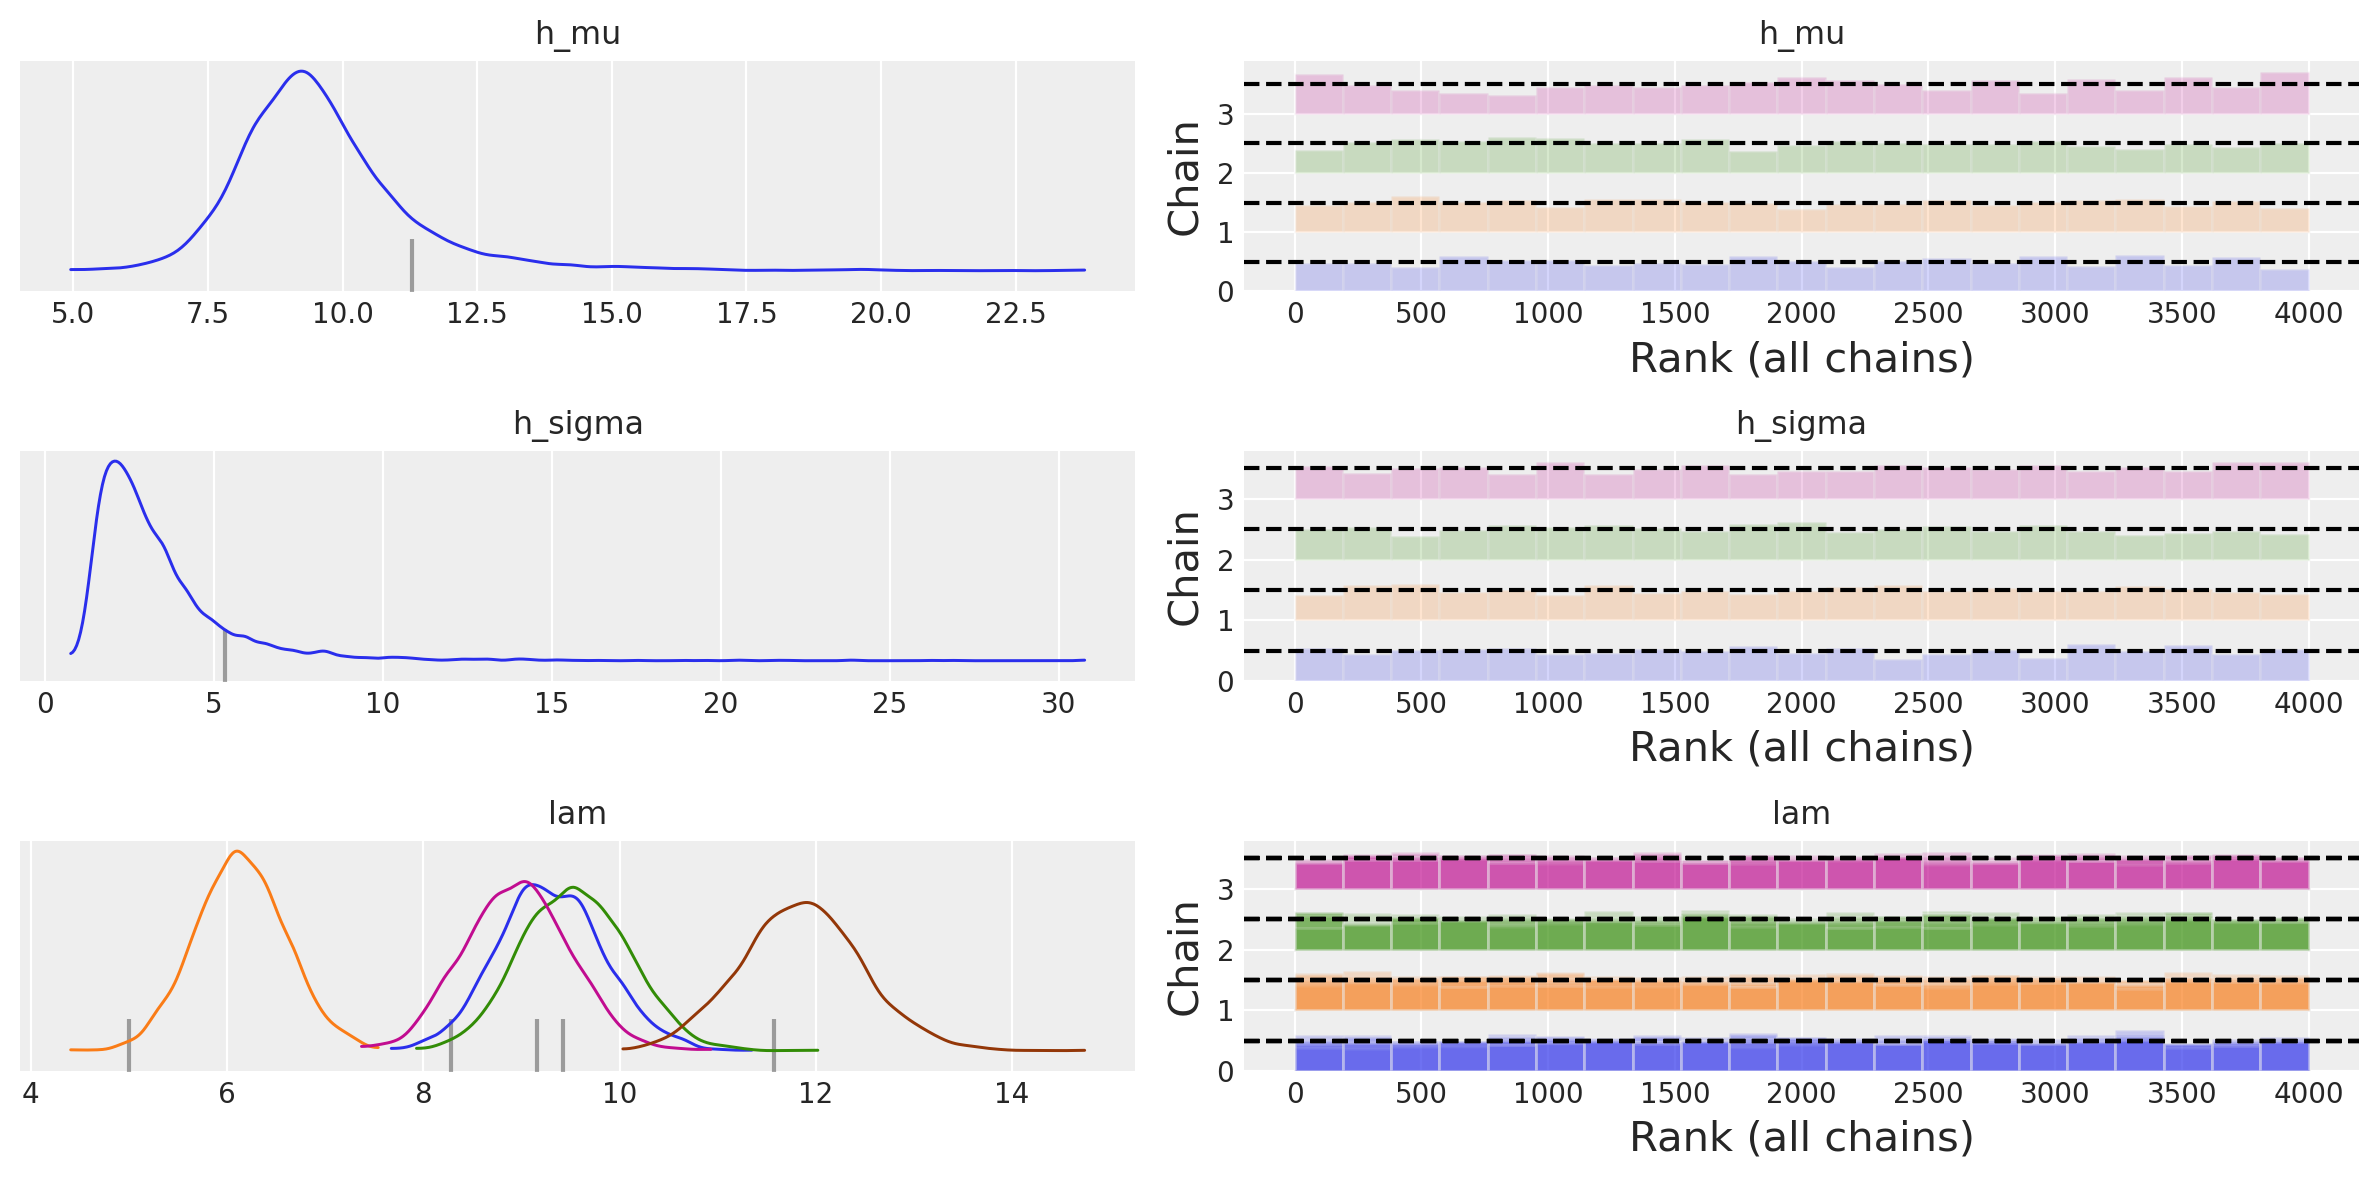

In [35]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()

In [36]:
dat_long.head()

,obs,location,patients
0,0,location_1,12
1,1,location_1,12
2,2,location_1,6
3,3,location_1,13
4,4,location_1,12


In [37]:
model_hierarchical = bmb.Model(
    "patients ~ 1 + (1 | location)", dat_long, family="poisson"
)

In [38]:
model_hierarchical_fitted = model_hierarchical.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    method="nuts_numpyro", 
    idata_kwargs={"log_likelihood": True},
)

Compiling...


Compilation time = 0:00:08.975643


Sampling...


  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 3:  55%|████████████████████████████████▍                          | 1650/3000 [00:01<00:00, 16443.05it/s]

Running chain 1:  70%|█████████████████████████████████████████▎                 | 2100/3000 [00:01<00:00, 20812.65it/s]

Running chain 0:  65%|██████████████████████████████████████▎                    | 1950/3000 [00:01<00:00, 18609.37it/s]

Running chain 2:  55%|████████████████████████████████▍                          | 1650/3000 [00:01<00:00, 15703.09it/s]

Running chain 0: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1877.25it/s]


Running chain 1: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1878.56it/s]


Running chain 2: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1880.04it/s]


Running chain 3: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1881.47it/s]

Sampling time = 0:00:01.694905


Transforming variables...


Transformation time = 0:00:00.092265


Computing Log Likelihood...


Log Likelihood time = 0:00:00.137284


In [39]:
summary = az.summary(model_hierarchical_fitted)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.178,0.243,1.794,2.702,0.027,0.020,108.0,39.0,1.04
1|location_sigma,0.441,0.359,0.107,1.405,0.066,0.048,102.0,42.0,1.05
1|location[location_1],0.048,0.249,-0.498,0.434,0.027,0.020,109.0,27.0,1.04
1|location[location_2],-0.370,0.248,-0.921,0.014,0.027,0.023,110.0,31.0,1.04
1|location[location_3],0.076,0.248,-0.477,0.492,0.027,0.020,110.0,38.0,1.04
1|location[location_4],0.009,0.246,-0.519,0.426,0.027,0.020,107.0,42.0,1.04
1|location[location_5],0.295,0.245,-0.261,0.669,0.026,0.019,110.0,33.0,1.03


In [40]:
(
    np.exp(summary["mean"][0] + summary["mean"][2]),
    np.exp(summary["mean"][0] + summary["mean"][3]),
    np.exp(summary["mean"][0] + summary["mean"][4]),
    np.exp(summary["mean"][0] + summary["mean"][5]),
    np.exp(summary["mean"][0] + summary["mean"][6]),
)

(9.262740914994835,
 6.098238750117821,
 9.52576278289445,
 8.908447643635347,
 11.857967446453067)

In [41]:
model_pooling = bmb.Model("patients ~ 1", dat_long, family="poisson")
model_pooling_fitted = model_pooling.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    method="nuts_numpyro", 
    idata_kwargs={"log_likelihood": True},
)

Compiling...


Compilation time = 0:00:01.508827


Sampling...


  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/3000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                         | 0/3000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2856.29it/s]


Running chain 1: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2859.18it/s]


Running chain 2: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2862.55it/s]


Running chain 3: 100%|████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2865.83it/s]


Sampling time = 0:00:01.100719


Transforming variables...


Transformation time = 0:00:00.026067


Computing Log Likelihood...


Log Likelihood time = 0:00:00.092803


In [42]:
summary2 = az.summary(model_pooling_fitted)
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.213,0.027,2.165,2.264,0.0,0.0,3171.0,3617.0,1.0


In [43]:
np.exp(summary2["mean"][0])

9.143104603994704

In [44]:
models = {"hierarchical": model_hierarchical_fitted, "pooling": model_pooling_fitted}
df_compare = az.compare(models)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-394.734627,5.852158,0.000000,0.978922,10.676386,0.000000,False,log
pooling,1,-421.936033,1.541919,27.201406,0.021078,13.365812,8.341653,False,log


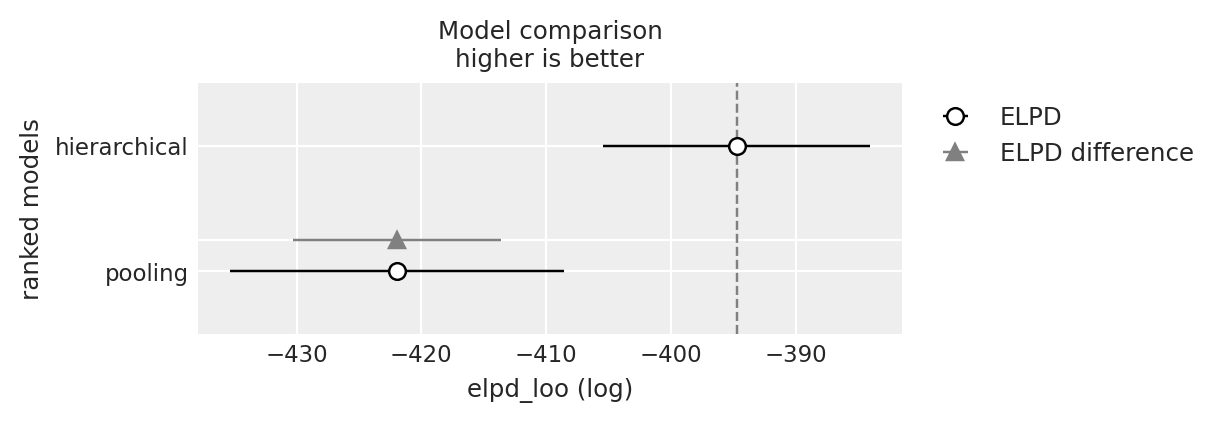

In [45]:
az.plot_compare(df_compare, insample_dev=False)
plt.show()

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Dec 10 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

pandas    : 2.1.3
numpy     : 1.26.2
matplotlib: 3.8.2
arviz     : 0.16.1
bambi     : 0.13.0
seaborn   : 0.13.0
scipy     : 1.11.4
pymc      : 5.10.0

Watermark: 2.4.3

